<a href="https://colab.research.google.com/github/Raanank10/Instagram-s-influencers/blob/Eladk_20211005/Instagram_influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instagram_influencers**

# Global Parameters

In [80]:
path_part0 = 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/ai_posts_analysis_data.xlsx'
fname = 'ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/main/ai_posts_analysis_data.xlsx'

path_part1= 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/project_part1.csv'
path_part2= 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/project_part2.csv'

train_size = 0.75
rand_state = 990
sigma = 3
Min_followers = 500

In [81]:
# Bining
bin_labels=['Low','Medium','High', 'Very High','Extreme']

# Get the Data

In [82]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno
import xgboost as xgb

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report # elad 20210708
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OrdinalEncoder # elad 20210911

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

## Concate the 3 files

In [83]:
df_part0 = pd.read_csv(path_part0, index_col=0)  
print(f'data len of df_part0 = {len(df_part0)}')
df_part0.head(2)

data len of df_part0 = 4792


,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,2530600951335029174,CMegChUlwm2,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, ...",FFP2 MADE IN ITALY????????#ffp2mask#italiansty...,NaN,NaN,NaN,1615891163,"Clothing, Apparel, Text, Money, Collage, Adver...",education,movies,business,https://instagram.fdok2-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN
1919,8210198494,pamela.latorre.73,Pamela La Torre,309,2595285287724490476,CQETjgBnZ7s,55,23,25.24,https://www.instagram.com/p/CQETjgBnZ7s,"Photo by Pamela La Torre on June 13, 2021. May...",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",NaN,1623602137,"Person, Human, Photographer, Photography, Phot...",news,arts_entertainment,style_fashion,https://instagram.fhel3-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN


In [84]:
df_part1 = pd.read_csv(path_part1, index_col=0) 
print(f'data len of df_part1 = {len(df_part1)}') 
df_part1.head(2)

data len of df_part1 = 18586


,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
24897,47655063851,_color_pal_ette,Asty,17,2.660000e+18,CTegsqAhtEs,959,0,5641.18,https://www.instagram.com/p/CTegsqAhtEs,NaN,......(50:7)\n....\n#islam#quran#islamic#verse...,NaN,NaN,NaN,1630923941,"Vegetation, Plant, Nature, Rainforest, Outdoor...",education,NaN,travel,https://scontent-hel3-1.cdninstagram.com/v/t51...,no,yes,yes,https://scontent-hel3-1.cdninstagram.com/v/t50...,1872.0
31286,47448521201,gigimakeup25,Gilliam Ibáñez ???????? makeup,157,2.660000e+18,CTsfWCeFunb,30,2147,1386.62,https://www.instagram.com/p/CTsfWCeFunb,Photo by Gilliam Ibáñez ???????? makeup on Sep...,???????????????? ???? SORTEO ????????????\n pa...,NaN,NaN,NaN,1631392946,"Flyer, Brochure, Advertisement, Poster, Paper,...",entertainment,style_fashion,business,https://instagram.frix2-1.fna.fbcdn.net/v/t51....,no,no,no,NaN,NaN


In [85]:
df_part2 = pd.read_csv(path_part2, index_col=0)  
print(f'data len of df_part2 = {len(df_part2)}') 
df_part2.head(2)

data len of df_part2 = 17471


,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
25807,40005237207,byeonggil6734,ç ‚å²¡????????????,717,2.550000e+18,CNfe10KrHnr,31,0,4.32,https://www.instagram.com/p/CNfe10KrHnr,"Photo by ç ‚å²¡???????????? on April 10, 2021....",ì£¼ë§ì—ëŠ” í•˜ë£¨ ìˆ˜ê³ í–ˆìŠµë‹ˆë‹¤ ë¶€ì‚°ì...,NaN,NaN,NaN,1618071572,"Chair, Furniture, Couch, Skin, Clothing, Appar...",education,arts_entertainment,style_fashion,https://instagram.fixb1-1.fna.fbcdn.net/v/t51....,yes,no,no,NaN,NaN
27121,17931150200,hitmanmikey,mikey_BANGZ,6182,2.650000e+18,CS5ZWqFD3uv,242,25,4.32,https://www.instagram.com/p/CS5ZWqFD3uv,NaN,(5-Step #Drill - #SubJazz Version)\n\n142 BPM ...,NaN,NaN,NaN,1629678866,"Poster, Advertisement, Symbol, Emblem, Logo, T...",arts_entertainment,NaN,business,https://instagram.fcvj4-1.fna.fbcdn.net/v/t51....,no,yes,yes,https://instagram.fcvj4-1.fna.fbcdn.net/v/t50....,3456.0


In [86]:
df = pd.concat([df_part0, df_part1, df_part2])
print(f'data len After concat all parts = {len(df)}')

data len After concat all parts = 40849


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40849 entries, 1918 to 37857
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          40849 non-null  int64  
 1   USERNAME                        40849 non-null  object 
 2   FULLNAME                        39489 non-null  object 
 3   FOLLOWER                        40849 non-null  int64  
 4   POST ID                         40849 non-null  float64
 5   SHORTCODE                       40849 non-null  object 
 6   LIKES                           40849 non-null  int64  
 7   COMMENTS                        40849 non-null  int64  
 8   ENGAGEMENT                      40849 non-null  float64
 9   URL                             40849 non-null  object 
 10  ACCESSIBILITY CAPTION           33725 non-null  object 
 11  CAPTION                         34786 non-null  object 
 12  LOCATION                     

In [88]:
print(f'data len Before = {len(df)}')
df = df[~df.index.duplicated()]
print(f'data len After  = {len(df)}')
df.info()

data len Before = 40849
data len After  = 36057
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36057 entries, 1918 to 37857
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          36057 non-null  int64  
 1   USERNAME                        36057 non-null  object 
 2   FULLNAME                        34823 non-null  object 
 3   FOLLOWER                        36057 non-null  int64  
 4   POST ID                         36057 non-null  float64
 5   SHORTCODE                       36057 non-null  object 
 6   LIKES                           36057 non-null  int64  
 7   COMMENTS                        36057 non-null  int64  
 8   ENGAGEMENT                      36057 non-null  float64
 9   URL                             36057 non-null  object 
 10  ACCESSIBILITY CAPTION           29782 non-null  object 
 11  CAPTION                         30476 non-

In [89]:
print(f'data len Before = {len(df)}')
df = df[df.FOLLOWER >= Min_followers]
print(f'data len Before = {len(df)}')
df.info()

data len Before = 36057
data len Before = 22123
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22123 entries, 1918 to 37546
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          22123 non-null  int64  
 1   USERNAME                        22123 non-null  object 
 2   FULLNAME                        21598 non-null  object 
 3   FOLLOWER                        22123 non-null  int64  
 4   POST ID                         22123 non-null  float64
 5   SHORTCODE                       22123 non-null  object 
 6   LIKES                           22123 non-null  int64  
 7   COMMENTS                        22123 non-null  int64  
 8   ENGAGEMENT                      22123 non-null  float64
 9   URL                             22123 non-null  object 
 10  ACCESSIBILITY CAPTION           17756 non-null  object 
 11  CAPTION                         20146 non-

# EDA

Column names: Replace white spaces with underscore 

In [90]:
df.columns = df.columns.str.replace(' ', '_')

Check for each column how many unique is there (lenght of the dataset 4792, len(df)) 

In [91]:
df.apply(lambda col: len(col.unique())).sort_values(ascending=False)

IMAGE_URL                         22123
SHORTCODE                         22075
URL                               22075
TIME                              22059
IMAGE_LABELS                      21317
CAPTION                           19283
ACCESSIBILITY_CAPTION             17077
VIDEO_URL                          4094
POST_ID                            3786
LOCATION                           3475
ENGAGEMENT                         2500
FULLNAME                           1975
CITY                               1955
USERNAME                           1947
USERID                             1947
FOLLOWER                           1571
LIKES                              1530
VIDEO_VIEW_COUNT                   1501
COMMENTS                            312
COUNTRY                             106
CAPTION_INTEREST                     37
IMAGE_LABEL_INTEREST                 36
ACCESSIBILITY_CAPTION_INTEREST       31
COMMENT_DISABLED                      2
IS_VIDEO                              2


## Data Cleaning

In [92]:
# Descriptive statistics for each column
df.describe()

,USERID,FOLLOWER,POST_ID,LIKES,COMMENTS,ENGAGEMENT,TIME,VIDEO_VIEW_COUNT
count,2.212300e+04,2.212300e+04,2.212300e+04,2.212300e+04,22123.000000,22123.000000,2.212300e+04,4.093000e+03
mean,1.294732e+10,5.353148e+04,2.560923e+18,1.012033e+03,29.686932,5.444202,1.619499e+09,1.448958e+04
std,1.635346e+10,1.011282e+06,1.702821e+17,2.267501e+04,706.415323,7.577142,2.029269e+07,2.316489e+05
min,3.142160e+05,5.000000e+02,6.216878e+17,0.000000e+00,0.000000,0.000000,1.388331e+09,0.000000e+00
25%,5.652381e+08,9.180000e+02,2.560000e+18,2.300000e+01,0.000000,1.270000,1.619573e+09,9.400000e+01
50%,4.459829e+09,1.616000e+03,2.610000e+18,5.700000e+01,3.000000,3.140000,1.624838e+09,2.350000e+02
75%,2.290415e+10,4.140000e+03,2.650000e+18,1.360000e+02,10.000000,6.960000,1.630711e+09,7.290000e+02
max,4.944817e+10,3.636130e+07,2.670000e+18,1.409732e+06,73188.000000,338.740000,1.632341e+09,9.785071e+06


In [93]:
df.isnull().sum()

USERID                                0
USERNAME                              0
FULLNAME                            525
FOLLOWER                              0
POST_ID                               0
SHORTCODE                             0
LIKES                                 0
COMMENTS                              0
ENGAGEMENT                            0
URL                                   0
ACCESSIBILITY_CAPTION              4367
CAPTION                            1977
LOCATION                          14635
CITY                              15128
COUNTRY                           15980
TIME                                  0
IMAGE_LABELS                         14
CAPTION_INTEREST                   1977
ACCESSIBILITY_CAPTION_INTEREST     4367
IMAGE_LABEL_INTEREST                 14
IMAGE_URL                             0
COMMENT_DISABLED                      0
IS_VIDEO                              0
HAS_AUDIO                             0
VIDEO_URL                         18030


In [94]:
print(f'data len Before = {len(df)}')
df = df[df['ENGAGEMENT'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


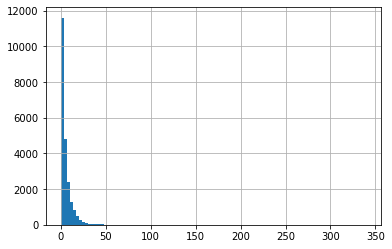

In [95]:
df.ENGAGEMENT.hist(bins=100)

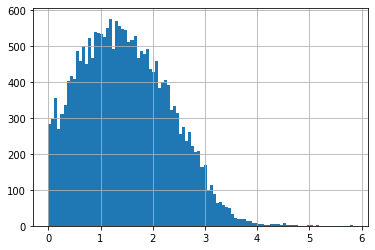

In [96]:
log_ENGAGEMENT = np.log1p(df.ENGAGEMENT)
log_ENGAGEMENT.hist(bins=100)

In [97]:
df['log_ENGAGEMENT'] = log_ENGAGEMENT

In [98]:
print(f'data len Before = {len(df)}')
df = df[df['LIKES'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


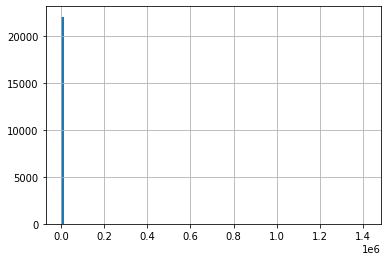

In [99]:
df.LIKES.hist(bins=100)

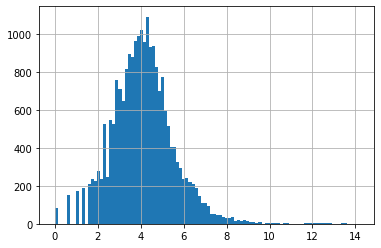

In [100]:
log_LIKES = np.log1p(df.LIKES)
log_LIKES.hist(bins=100)

In [101]:
df['log_LIKES'] = log_LIKES

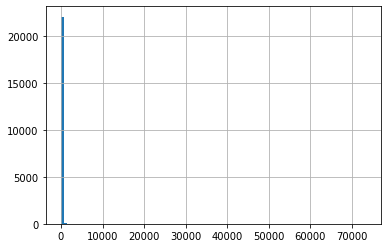

In [102]:
df.COMMENTS.hist(bins=100)

In [103]:
print(f'data len Before = {len(df)}')
df = df[df['COMMENTS'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


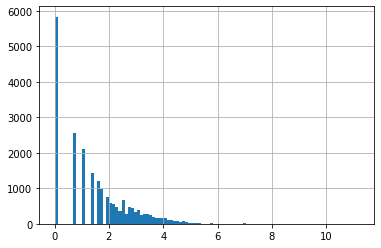

In [104]:
log_COMMENTS = np.log1p(df.COMMENTS)
log_COMMENTS.hist(bins=100)

In [105]:
df['log_COMMENTS'] = log_COMMENTS

##Feature Engeering - Unstack IMAGE_LABELS, 

In [106]:
df['IMAGE_LABELS'].unique()

array(['Clothing, Apparel, Text, Money, Collage, Advertisement, Poster',
       'Clothing, Apparel, Person, Human, Female, Swimwear, Footwear, Woman, Bikini, Shoe, Skin, Pants, Flooring, Girl',
       'Clothing, Apparel, Person, Human, Sunglasses, Accessories, Accessory, Face, Scarf, Portrait, Photography, Photo, Glasses, People, Selfie, Female, Coat, Smile',
       ...,
       'Coin, Money, Gold, Flyer, Advertisement, Paper, Poster, Brochure',
       'Nature, Outdoors, Sky, Azure Sky, Horizon, Ice',
       'Face, Person, Human, Female, Plant, Tree, Clothing, Apparel, Woman, Portrait, Photography, Photo, Girl, Palm Tree, Arecaceae, Smile, Selfie, Glasses, Accessories, Accessory, Laughing'],
      dtype=object)

In [107]:
df['CAPTION_INTEREST'].unique()

array(['education', nan, 'entertainment', 'desserts_baking',
       'dating_and_relationships', 'arts_entertainment', 'business',
       'gaming', 'travel', 'news', 'music', 'politics', 'pets',
       'food_drink', 'parenting', 'style_fashion', 'humor', 'sports',
       'accessories', 'technology_computing', 'health', 'home_garden',
       'weddings', 'books_literature', 'legal', 'movies', 'fitness',
       'chef', 'events', 'baking_cooking', 'comic_books',
       'cars_motorcycles', 'hobbies_interests', 'podcasts',
       'green_living', 'barbecues_grilling', 'finance'], dtype=object)

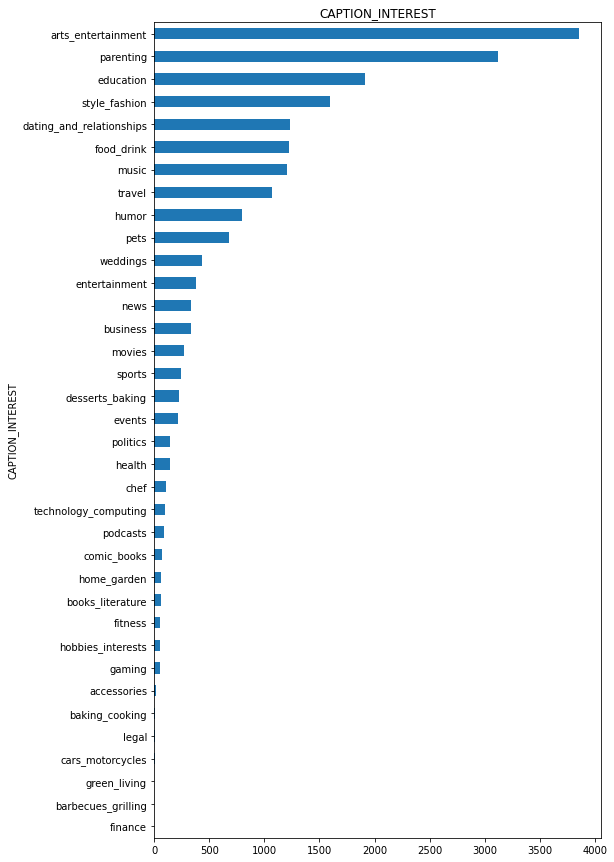

In [108]:
IMAGE_LABELS = df.groupby('CAPTION_INTEREST').size().sort_values()
IMAGE_LABELS.plot.barh(figsize=(8, 15), fontsize=10, title='CAPTION_INTEREST')

In [ ]:
IMAGE_LABELS = df.groupby('IMAGE_LABELS').size().sort_values()
IMAGE_LABELS.plot.barh(figsize=(8, 15), fontsize=10, title='IMAGE_LABELS')

## Sigma cleaning

In [ ]:
# # we lose the most viral posts and most unviral posts
# for col in df.columns:
#     if df[col].dtype == 'float64':
#         std = df[col].std()
#         ave = df[col].mean()
#         df = df.loc[df[col].between\
#                                (ave - (sigma * std), ave + (sigma * std))] 
#         print(f'Processing {col:10} --> {df.shape[0]:5} entities entries remain')

In [ ]:
df.describe()

## Handle NaN valus

How Many NaN values are ther in the datast?

In [ ]:
msno.matrix(df)

In [ ]:
msno.bar(df, figsize=(20, 8))

Conert unix time to separate Date and Time columns

In [ ]:
df['DATETIME'] = pd.to_datetime(df['TIME'],unit='s')

In [ ]:
df['YEAR'] = pd.DatetimeIndex(df['DATETIME']).year
df['MONTH'] = pd.DatetimeIndex(df['DATETIME']).month
df['DAY'] = pd.DatetimeIndex(df['DATETIME']).day
df['DAYOFWEEK'] = pd.DatetimeIndex(df['DATETIME']).dayofweek
df['HOUR'] = pd.DatetimeIndex(df['DATETIME']).hour
df['MINUTE'] = pd.DatetimeIndex(df['DATETIME']).minute

In [ ]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

In [ ]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

In [ ]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

In [ ]:
# per_FULLNAME = df.groupby(['USERNAME']).sum()
# per_FULLNAME.plot(y=["ENGAGEMENT", "LIKES","COMMENTS"], kind="bar",figsize=(12,8))

# plt.title("Total ENGAGEMENT, LIKES, COMMENTS per state",fontsize=15)
# plt.xlabel('FULLNAME',fontsize=12)
# plt.ylabel('ENGAGEMENT, LIKES, COMMENTS',fontsize=12)

Remove column that all values are unique:

In [ ]:
for col in df.columns:
    if len(df[col].unique()) == len(df):
        print(col)
        #df.drop(col,inplace=True,axis=1)

In [ ]:
df.head()

In [ ]:
df.URL.head()
# SHORTCODE
# URL
# IMAGE_URL
# VIDEO_URL # Not working

## Remove unneccessary columns from Dataframe

In [ ]:
df.drop(['POST_ID','VIDEO_URL','SHORTCODE','IMAGE_URL','USERID','FULLNAME','USERNAME',
         'USERID','TIME','URL','VIDEO_VIEW_COUNT'],inplace=True,axis=1)

After talking with Royi on 1-Oct: 

In [ ]:
df.info()

Convert columns type to characters :

In [ ]:
df['COMMENT_DISABLED'].value_counts()

In [ ]:
df['COMMENT_DISABLED'] = df['COMMENT_DISABLED'].map(dict(yes=1, no=0))

In [ ]:
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))

In [ ]:
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [ ]:
df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].value_counts()

In [ ]:
pd.unique(df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].values.ravel('K'))

In [ ]:
msno.matrix(df)

In [ ]:
df.columns

Raname the index

In [ ]:
df = df.rename_axis('LINE_NUM_INDEX')

Note by Eladk: we can fill location values by using a merdiction model base in the influancer and the time for the post. <BR> 
For Now, I'll just fill the columns with NULL

Replace all cases where VIDEO_VIEW_COUNT == Nan with 0. <BR> for double check i verified it with is_video column

Eladk note 8-Sep-2021: I still need to handle missing values in column:


*   FULLNAME
*   ACCESSIBILITY_CAPTION - specify full name, time, location, video or picture and tag
*   CAPTION - the text on this post (by the post uploader
*   LOCATION, CITY, COUNTRY - location
*   CAPTION_INTEREST -
*   ACCESSIBILITY_CAPTION_INTEREST


In [ ]:
msno.matrix(df)

In [ ]:
df.CAPTION.value_counts().sort_values(ascending=False)

selecting a subset of the data:

In [ ]:
df[['ACCESSIBILITY_CAPTION','CAPTION','LOCATION', 'CITY', 'COUNTRY'\
    ,'CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(5)

Increase the length to a column so that we'll see all the text in a cell

In [ ]:
pd.options.display.max_colwidth = 1000
df.ACCESSIBILITY_CAPTION.head(5)

Selecting 1 row by index (specific column only)

In [ ]:
#df[df.index == 1929][['URL','ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 
df[df.index == 1929][['ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 

In [ ]:
df.columns

In [ ]:
df[['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(20)

In [ ]:
#df[df.index == 1932][['URL','CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name, 
df[df.index == 1932][['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name,

there are 308 combination as CAPTION_INTEREST and ACCESSIBILITY_CAPTION_INTEREST

In [ ]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

there are 35 unique CAPTION_INTEREST


In [ ]:
df.groupby(['CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

there are 26 unique ACCESSIBILITY_CAPTION_INTEREST


In [ ]:
df.groupby(['ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(30)

Eladk 1-Oct , creat new column the state if CAPTION_INTEREST == ACCESSIBILITY_CAPTION_INTEREST

In [ ]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

For Now (Eladk 2021-Sep-11) I'll fill every NaN with Null

In [ ]:
msno.matrix(df)

In [ ]:
#https://datatofish.com/rows-with-nan-pandas-dataframe/
#len(df[df['FULLNAME'].isna()]) # 126 #849
#df[df['FULLNAME'].isnull()]
#df[df.isna().any(axis=1)] # len = 4020
# df[df.isnull().any(axis=1)]

In [ ]:
for col in df.columns:
    if len(df[df[col].isnull()]) > 0:
      df[col] = df[col].fillna('Null')
      print(col)

In [ ]:
msno.matrix(df)

In [ ]:
df.IMAGE_LABEL_INTEREST.unique()

In [ ]:
df.IMAGE_LABEL_INTEREST.value_counts()

In [ ]:
IMAGE_LABEL_INTEREST = df.groupby(['IMAGE_LABEL_INTEREST']).head(10)
print(IMAGE_LABEL_INTEREST)

## Create bins (buckets) of Likes, Comment Engagement so we can use a classification model

In [ ]:
sns.histplot(x = df.LIKES,bins=50)

In [ ]:
bins_LIKES=[min(df.LIKES)-1,15,40,200,400,max(df.LIKES)+1]
pd.cut(x=df.LIKES, bins=5).value_counts()
pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
       ordered=True).value_counts()

In [ ]:
df['LIKES_RANK'] = pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
       ordered=True)

In [ ]:
sns.histplot(x = df.COMMENTS,bins=50)

In [ ]:
len(df.COMMENTS) #3921

In [ ]:
bins_COMMENTS=[min(df.COMMENTS)-1,1,5,40,60,max(df.COMMENTS)]
#pd.cut(x=df.COMMENTS, bins=5).value_counts()
pd.cut(x=df.COMMENTS, bins=bins_COMMENTS#, labels=labels 
        ,ordered=True).value_counts()

In [ ]:
df['COMMENTS_RANK'] = pd.cut(x=df.COMMENTS, bins=bins_COMMENTS, labels=bin_labels 
        ,ordered=True)

In [ ]:
sns.histplot(x = df.ENGAGEMENT,bins=50)

In [ ]:
bins_ENGAGEMENT=[min(df.ENGAGEMENT)-1,1.5,3.5,10,15,max(df.ENGAGEMENT)]
pd.cut(x=df.ENGAGEMENT, bins=5, labels=bin_labels, ordered=True).value_counts()
pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True).value_counts()

In [ ]:
df['ENGAGEMENT_RANK'] = pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True)

In [ ]:
df['ENGAGEMENT_RANK']

Convert Rank to Code using Dictionary 

In [ ]:
df.columns

In [ ]:
df.LIKES_RANK.unique()

In [ ]:
df['COMMENTS_RANK']

In [ ]:
map_dict_rank = {'Low':0.0 , 'Medium':1.0, 'High':2.0, 'Very High':3.0, 'Extreme':4.0}
map_dict_rank

In [ ]:
df['LIKES_RANK_INT'] =  df['LIKES_RANK'].map(map_dict_rank).astype(int)

In [ ]:
df['COMMENTS_RANK_INT'] =   df['COMMENTS_RANK'].map(map_dict_rank).astype(int)

In [ ]:
df['ENGAGEMENT_RANK_INT'] =   df['ENGAGEMENT_RANK'].map(map_dict_rank).astype(int)

In [ ]:
df[['LIKES_RANK','LIKES_RANK_INT']].value_counts().sort_index()

In [ ]:
df[['COMMENTS_RANK','COMMENTS_RANK_INT']].value_counts().sort_index()

In [ ]:
df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_INT']].value_counts().sort_index()

In [ ]:
p = sns.violinplot(x='ENGAGEMENT_RANK', y='ENGAGEMENT', 
                    #order=cut_order, 
                    data=df)

## Eladk 28-Sep-2021, more bucketing



1.  VIDEO_VIEW_COUNT          41.148879
2.  FOLLOWER                  35.852012
3.  USERNAME_OBJECT_AS_INT    17.961764
4.  CAPTION_OBJECT_AS_INT      3.558228
5.  HOUR                       1.201713
6.  MINUTE                     0.277403



In [ ]:
df.FOLLOWER.value_counts().sort_values(ascending=False).plot.bar()
#.reindex()

## Replacing Charecters  with Number uning OrdinalEncoder

In [ ]:
# list of char / object columns

In [ ]:
df.dtypes

In [ ]:
df.select_dtypes(include=['object']).dtypes

In [ ]:
df.select_dtypes(include=['object']).dtypes.index

In [ ]:
df.info()

In [ ]:
enc = OrdinalEncoder()

Many columns:

In [ ]:
for col in df.select_dtypes(include=['object']).dtypes.index:
#for col in ['USERNAME','FULLNAME']:
  #col_list = pd.DataFrame(df[col].unique())
  #col_list.rename(columns = {0:col},inplace=True)
  #col_list.rename(columns = {0:col},inplace=True)
  enc.fit(df[[col]])
  df[col + '_OBJECT_AS_INT'] = enc.transform(df[[col]])
  #print(col)

In [ ]:
df.info()

In [ ]:
df.head(2)

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Relationship Between The Features of The instagram Data")
sns.heatmap(df.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [ ]:
# %%time 
# df = df.select_dtypes(include=np.number)
# sns.pairplot(df ,height=1.8) # takes about 5 min.

## More EDA

In [ ]:
df.head(2)

## Feature Engneering

## Image captioning

Eladk 2021-Sep-17, we need to:


*   convert y colum to 5 classes so we can have a classification problem and not a regresion model
*   check if the data is inbalance (so we need to use stratify)



# Split the Data for image or video post

In [ ]:
df.info()

In [ ]:
df_image = df[df['IS_VIDEO'] == 'no']
df_image.info()

In [ ]:
df_video = df[df['IS_VIDEO']=='yes']
df_video.info()

# Split the Data for modules

select only int and float column types to X 
seletc LIKES, COMMENTS, ENGAGEMENT as y

In [ ]:
df_image.columns

In [ ]:
df_video.columns

In [ ]:
X = df.select_dtypes(include=['number'])
X.drop(['LIKES','COMMENTS','ENGAGEMENT','log_ENGAGEMENT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
X.drop(['LIKES_RANK_INT','COMMENTS_RANK_INT','ENGAGEMENT_RANK_INT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
y = df['ENGAGEMENT']
y1 = df['LIKES']
y2 = df['COMMENTS']
y3 = df['log_ENGAGEMENT']
y_ENGAGEMENT_RANK_INT = df['ENGAGEMENT_RANK_INT']
y_LIKES_RANK_INT = df['LIKES_RANK_INT']
y_COMMENTS_RANK_INT = df['COMMENTS_RANK_INT']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y3, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels (y) Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels(y) Shape:', y_test.shape)

# Mechine Learning  Model for df_image

## Appling First1 Model - KNN model

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = (mse(y_test,pred))**0.5 #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

In [ ]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [ ]:
min_mse_k = min(rmse_val)
min_index = rmse_val.index(min_mse_k)
print(min_index, min_mse_k)

In [ ]:
neighbor = min_index
knn_model_1 = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train, y_train)

In [ ]:
y_train_pred = knn_model_1.predict(X_train)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(y_train[-150:]))), y=y_train[-150:],
                         mode='lines',
                         name='Prediction'))
fig.add_trace(go.Scatter(x=list(range(len(y_train_pred[-150:]))), y=y_train_pred[-150:],
                         mode='lines',
                         name='True value'))

fig.show()

## Validating the Model 

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
y_test_pred = knn_model_1.predict(X_test)
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
print('RMSE ', RMSE)

print('r2_score: ', round(r2_score(y_test, y_test_pred)*100, 2))

## Scaled MaxAbsScaler model

In [ ]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors=10).fit(X_train_scaled, y_train)

In [ ]:
y_train_pred = knn_model_2.predict(X_train_scaled)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
X_test_scaled = my_scaler.transform(X_test)
y_test_pred = knn_model_2.predict(X_test_scaled)

ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

## Appling 2nd Model - Decision Tree with bins

In [ ]:
model_2_dt = DecisionTreeClassifier(
    min_samples_leaf=3
    ,max_depth=5
    )

In [ ]:
model_2_dt.fit(X, 
              y_ENGAGEMENT_RANK_INT)

In [ ]:
model_2_dt_pred_like.fit(X, 
              y_LIKES_RANK_INT)

In [ ]:
model_2_dt_pred_comments.fit(X, 
              y_COMMENTS_RANK_INT)

In [ ]:
class_list = [str(x) for x in model_2_dt.classes_]
class_list

In [ ]:
dot_data = StringIO()  
export_graphviz(model_2_dt, out_file=dot_data, feature_names=X.columns, 
                leaves_parallel=True, filled=True, class_names=[str(x) for x in model_2_dt.classes_])
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

View Features Emportance:

In [ ]:
pd.Series(model_2_dt.feature_importances_*100,
          index=X.columns).sort_values(ascending=False).round()

Eladk 2021-Sep-24 comment in first model:

*   Why Time is So meaning full?
*   What ACCESSIBILITY_CAPTION have corolation with ranking?
*   I Need to understand why folloer is very meaningfull
*   I Need to understand why USERNAME,userid is very meaningfull

In [ ]:
df.head(3)

In [ ]:
df['ENGAGEMENT_RANK_INT_pred'] = model_2_dt.predict(X)
df.head(3)

In [ ]:
s = pd.Series(model_2_dt.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

In [ ]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))
# map_dict_ENGAGEMENT

In [ ]:
#df['ENGAGEMENT_RANK_pred'] = df['ENGAGEMENT_RANK_INT_pred'].map(map_dict_ENGAGEMENT)

Evanuating the Model:

In [ ]:
#type(df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_pred']].value_counts())

In [ ]:
df[['ENGAGEMENT_RANK_INT','ENGAGEMENT_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
#df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_pred']].value_counts().sort_index()

In [ ]:
cm = confusion_matrix(y_true=df.ENGAGEMENT_RANK_INT,
                      y_pred=df.ENGAGEMENT_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt.classes_,
             columns=model_2_dt.classes_)

In [ ]:
print(classification_report(y_true=df.ENGAGEMENT_RANK_INT,
                      y_pred=df.ENGAGEMENT_RANK_INT_pred))

In [ ]:
accuracy_score(y_true=df.ENGAGEMENT_RANK_INT, y_pred=df.ENGAGEMENT_RANK_INT_pred)

In [ ]:
s = pd.Series(model_2_dt.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

In [ ]:
p = sns.violinplot(x='ENGAGEMENT_RANK', y='HOUR', 
                    #order=cut_order, 
                    data=df)

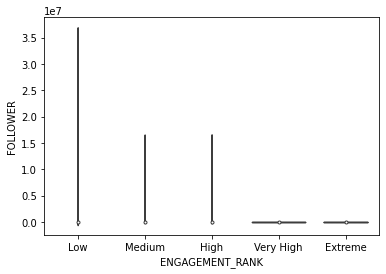

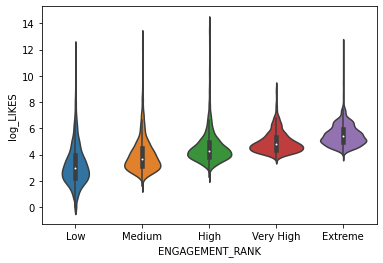

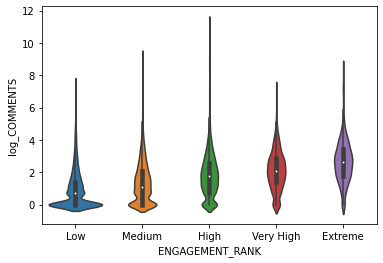

In [ ]:
for index, val in pd.Series(model_2_dt.feature_importances_*100,index=X.columns).iteritems():
  if val > 0:
    plt.figure()
    p = sns.violinplot(x='ENGAGEMENT_RANK', y=index, 
                    #order=cut_order, 
                    data=df)
    

## Scoring 

## Appling 3nd Model - Random Forest regression

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = rand_state)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(rf_predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'log_of_enegament.')

Mean Absolute Error: 0.02 log_of_enegament.


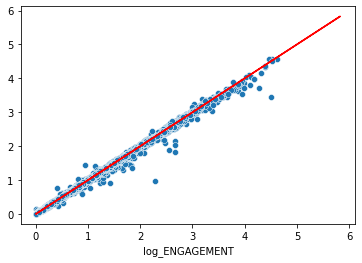

In [ ]:
ax = sns.scatterplot(x=y_test, y=rf_predictions)
ax.plot(y_train, y_train, 'r')

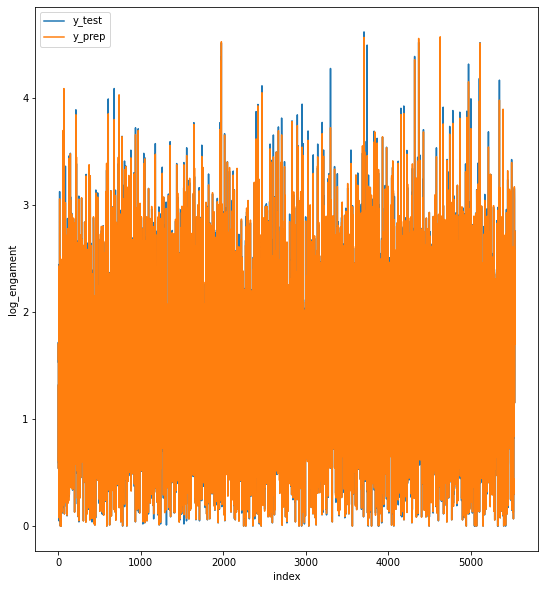

In [ ]:
x = np.linspace(0, len(y_test), len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x, y_test, label='y_test')
plt.plot(x, rf_predictions, label='y_prep')
plt.xlabel('index')
plt.ylabel('log_engament')
plt.legend()
plt.show()

In [ ]:
rf_y_train_pred = rf.predict(X_train)
RMSE = mse(y_train, rf_y_train_pred)**0.5
RMSE

0.02183439965154419

In [ ]:
rf_y_test_pred = rf.predict(X_test)
RMSE = mse(y_test, rf_y_test_pred)**0.5
RMSE


0.049846423934298445

In [ ]:
pd.Series(rf.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)

log_LIKES                                       0.568706
FOLLOWER                                        0.419867
log_COMMENTS                                    0.008330
CAPTION_OBJECT_AS_INT                           0.000366
DAY                                             0.000304
HOUR                                            0.000299
ACCESSIBILITY_CAPTION_OBJECT_AS_INT             0.000294
MINUTE                                          0.000282
IMAGE_LABELS_OBJECT_AS_INT                      0.000271
IMAGE_LABEL_INTEREST_OBJECT_AS_INT              0.000232
CAPTION_INTEREST_OBJECT_AS_INT                  0.000203
MONTH                                           0.000176
DAYOFWEEK                                       0.000171
ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT    0.000140
LOCATION_OBJECT_AS_INT                          0.000097
CITY_OBJECT_AS_INT                              0.000085
COUNTRY_OBJECT_AS_INT                           0.000083
YEAR                           

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 990,
 'verbose': 0,
 'warm_start': False}


In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 35, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
#Model Performance
#Average Error: 3.6561 degrees.
#Accuracy = 93.83%.
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
#Improvement of 0.50%.

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
grid_search.best_params_

## Appling 4nd Model - Random Forest Classification 

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_LIKES_RANK_INT, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_COMMENTS_RANK_INT, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
X_train_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)
X_test_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)

In [ ]:
X_train_4.columns

In [ ]:
model_rf_4 = RandomForestClassifier()

model_rf_4.fit(X_train_4,y_train_4) # X_test_4 is Engagment_rank
preds= model_rf_4.predict_proba(X_train_4)[:,1]

#roc_auc_score(y_test_4,preds)

In [ ]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))

In [ ]:
pd.Series(model_rf_4.feature_importances_*100, index=X_train_4.columns).sort_values(ascending=False).round()#.plot.barh(figsize=(14,12))

In [ ]:
from sklearn import tree

In [ ]:
import six

In [ ]:
_ = tree.plot_tree(model_rf_4.estimators_[0], feature_names=X_train_4.columns, filled=True)

In [ ]:
X_train_4.columns

In [ ]:
X_train_4.head(3)

In [ ]:
X_train_4['y_ENGAGEMENT_RANK_INT_pred_rf'] = model_rf_4.predict(X_train_4)

In [ ]:
X_train_4.head(3)

In [ ]:
X_train_4 = pd.concat([X_train_4, y_train_4], axis=1).reset_index()

In [ ]:
X_train_4.head(3)

In [ ]:
print(len(X_train_4))

In [ ]:
len(X_train_4[X_train_4.y_ENGAGEMENT_RANK_INT_pred_rf == X_train_4.ENGAGEMENT_RANK_INT])

In [ ]:
cm = confusion_matrix(y_true=y_train_4,
                      y_pred=X_train_4['y_ENGAGEMENT_RANK_INT_pred_rf'])
pd.DataFrame(cm,
             index=model_rf_4.classes_,
             columns=model_rf_4.classes_)

In [ ]:
X_train_4.columns

In [ ]:
print(classification_report(y_true=y_train_4,
                      y_pred=X_train_4.y_ENGAGEMENT_RANK_INT_pred_rf))

**WTF!!!**

In [ ]:
print(classification_report(y_true=df.ENGAGEMENT_RANK_INT,
                      y_pred=df.ENGAGEMENT_RANK_INT_pred))

In [ ]:
X_test_4.columns

In [ ]:
X_test_4.head(3)

In [ ]:
X_test_4['y_ENGAGEMENT_RANK_INT_pred'] = model_rf_4.predict(X_test_4)

In [ ]:
X_test_4.head(3)

In [ ]:
#pd.concat([X_test_4, df4.reindex(df1.index)], axis=1)
X_test_4 = pd.concat([X_test_4, y_test_4], axis=1).reindex(X_test_4.index)

In [ ]:
X_test_4.head(3)

In [ ]:
X_test_4[['ENGAGEMENT_RANK_INT','y_ENGAGEMENT_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
cm = confusion_matrix(y_true=X_test_4.ENGAGEMENT_RANK_INT,
                      y_pred=X_test_4.y_ENGAGEMENT_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt.classes_,
             columns=model_2_dt.classes_)

In [ ]:
print(classification_report(y_test_4,
                      y_pred=X_test_4.y_ENGAGEMENT_RANK_INT_pred))

Visualize the Random Forest:

In [ ]:
# dotfile = six.StringIO()
# i_tree = 0
# for tree_in_forest in model_rf_4.estimators_:
#   if (i_tree <1):        
#       export_graphviz(model_rf_4,
#                   feature_names=X_train_4.columns,
#                   filled=True,
#                   rounded=True)
#       pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png('dtree'+ str(i_tree) +'.png')
#       i_tree = i_tree + 1

## Appling 4nd Model - XGBoost regression


In [ ]:
XGB_reg = xgb.XGBRegressor()

In [ ]:
print(XGB_reg)

In [ ]:
XGB_reg.fit(X_train, y_train)

In [ ]:
score = XGB_reg.score(X_train, y_train)  
print("Training score: ", score)

In [ ]:
scores = cross_val_score(XGB_reg, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
y_test_pred = XGB_reg.predict(X_test)
mse = mse(y_test, y_test_pred)
score_test = XGB_reg.score(X_test, y_test)  
print("Training score: ", score_test)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**0.5))


In [ ]:
x_ax = range(len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

In [ ]:
XGB_param_grid = {'colsample_bytree': [0.3, 0.7, 1.0, 1.2],
    'n_estimators': [50,100,200],    'max_depth': [2,3,4]
}
XGB_reg_grid = xgb.XGBRegressor()
grid_mse = GridSearchCV(param_grid=XGB_param_grid, estimator=XGB_reg_grid, 
                        scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_mse.fit(X, y)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))